# 04. Actionable Explanations

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

REPORT_IMG_DIR = "../report/images"
os.makedirs(REPORT_IMG_DIR, exist_ok=True)
PROCESSED_DIR = "../data/processed"
MODELS_DIR = "../models"


## 1. Cargar Datos y Modelo

In [2]:
train_df = pd.read_csv(os.path.join(PROCESSED_DIR, "train.csv"))
val_df = pd.read_csv(os.path.join(PROCESSED_DIR, "val.csv"))
X_val = val_df.drop(columns=['Target'])
y_val = val_df['Target']
model_pipeline = joblib.load(os.path.join(MODELS_DIR, "rf_model.joblib"))

## 2. Fairness Analysis
Para jóvenes (< 25 años).

Tasa de Aprobación (Predicción = 0) por Grupo:
Age_Group
Adult (>=25)    0.77381
Young (<25)     0.59375
Name: Pred, dtype: float64


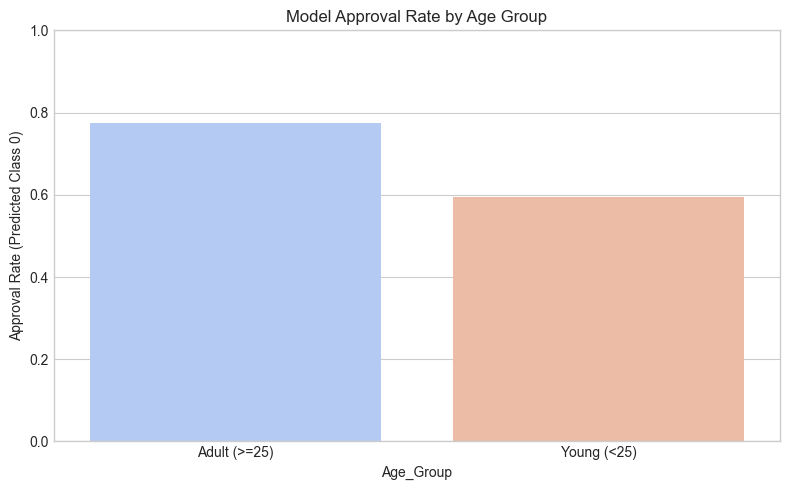

In [8]:
val_df['Age_Group'] = np.where(val_df['Age'] < 25, 'Young (<25)', 'Adult (>=25)')
val_df['Pred'] = model_pipeline.predict(X_val)
val_df['Pred_Proba'] = model_pipeline.predict_proba(X_val)[:, 1]

approval_rates = val_df.groupby('Age_Group')['Pred'].apply(lambda x: (x == 0).mean())
print("Tasa de Aprobación (Predicción = 0) por Grupo:")
print(approval_rates)

plt.figure(figsize=(8, 5))
sns.barplot(x=approval_rates.index, y=approval_rates.values, palette='coolwarm')
plt.title("Model Approval Rate by Age Group")
plt.ylabel("Approval Rate (Predicted Class 0)")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(os.path.join(REPORT_IMG_DIR, "10_fairness_age.png"), dpi=300)
plt.show()

In [ ]:
def get_metrics(df_group):
    y_true = df_group['Target']
    y_pred = df_group['Pred']
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return pd.Series({'FPR': fpr, 'FNR': fnr, 'Count': len(df_group)})

metrics_by_group = val_df.groupby('Age_Group').apply(get_metrics)
print("\nMatrix de Errores por Grupo:")
print(metrics_by_group)


Matrix de Errores por Grupo:
                   FPR       FNR  Count
Age_Group                              
Adult (>=25)  0.154472  0.577778  168.0
Young (<25)   0.294118  0.466667   32.0


In [31]:
# 1. Baseline Evaluation
y_pred_baseline = model_pipeline.predict(X_val)
acc_baseline = accuracy_score(y_val, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_val, y_pred_baseline)
print(f"Baseline Model Accuracy: {acc_baseline:.4f}")
print(f"Baseline Model ROC AUC: {roc_auc_baseline:.4f}")

# 2. Simplified Model
top_features = ['Status_Checking_Account', 
                'Duration_in_Months', 
                'Credit_History', 
                'Credit_Amount', 
                'Savings_Account', 
                # 'Age', 
                'Purpose', 
                'Present_Employment_Since',
                'Other_Installment_Plans',
                'Other_Debtors',
                'Telephone']

X_train_simple = train_df[top_features]
y_train = train_df['Target']
X_val_simple = val_df[top_features]
num_cols_simple = [c for c in top_features if X_train_simple[c].dtype in ['int64', 'float64']]
cat_cols_simple = [c for c in top_features if X_train_simple[c].dtype == 'object']
preprocessor_simple = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols_simple),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_cols_simple)
    ])
simple_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_simple),
    ('classifier', RandomForestClassifier(n_estimators=35, max_depth=10, random_state=42, class_weight='balanced'))
])
simple_model_pipeline.fit(X_train_simple, y_train)


y_pred_simple = simple_model_pipeline.predict(X_val_simple)
acc_simple = accuracy_score(y_val, y_pred_simple)
print(f"Simplified Model Accuracy: {acc_simple:.4f}")
roc_auc_simple = roc_auc_score(y_val, y_pred_simple)
print(f"Simplified Model ROC AUC: {roc_auc_simple:.4f}")

Baseline Model Accuracy: 0.7150
Baseline Model ROC AUC: 0.6393
Simplified Model Accuracy: 0.7450
Simplified Model ROC AUC: 0.6940
